<a href="https://colab.research.google.com/github/seunghokimS/DACON-Agricultural-product-price-prediction-/blob/main/%EB%86%8D%EC%82%B0%EB%AC%BC%EA%B0%80%EA%B2%A9%EC%98%88%EC%B8%A1(Dacon)(11_10)_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install lightgbm

In [ ]:
 ! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
# from pmdarima import auto_arima

import optuna
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/공모전(Dacon)/temp_train.csv")
test = pd.read_csv("/content/drive/MyDrive/공모전(Dacon)/df_test.csv")
sub_df = pd.read_csv("/content/drive/MyDrive/공모전(Dacon)/sample_submission.csv")

In [ ]:
df_train = train.copy()
df_test = test.copy()

In [ ]:
df_train = df_train.drop(columns = ['supply(kg)'])

In [ ]:
df_train

,timestamp,ID,item,corporation,location,price(원/kg),holiday,year,month,day
0,2019-01-03,TG_A_J_20190103,TG,A,J,1728.0,N,2019,1,3
1,2019-01-04,TG_A_J_20190104,TG,A,J,1408.0,N,2019,1,4
2,2019-01-05,TG_A_J_20190105,TG,A,J,1250.0,N,2019,1,5
3,2019-01-07,TG_A_J_20190107,TG,A,J,1474.0,N,2019,1,7
4,2019-01-08,TG_A_J_20190108,TG,A,J,1326.0,N,2019,1,8
...,...,...,...,...,...,...,...,...,...,...
20318,2023-02-23,CB_F_J_20230223,CB,F,J,631.0,N,2023,2,23
20319,2023-02-24,CB_F_J_20230224,CB,F,J,641.0,N,2023,2,24
20320,2023-02-25,CB_F_J_20230225,CB,F,J,579.0,N,2023,2,25
20321,2023-02-27,CB_F_J_20230227,CB,F,J,652.0,N,2023,2,27


#  label encoding

In [ ]:
col = ['item','corporation', 'location','holiday']

for i in col:
  encoder = LabelEncoder()
  df_train[i] = encoder.fit_transform(df_train[i])
  df_test[i] = encoder.transform(df_test[i])
  # test fit은 Data leakage



In [ ]:
# tg_df = df_train[df_train['ID'].str.contains('TG')]
# bc_df = df_train[df_train['ID'].str.contains('BC')]
# rd_df = df_train[df_train['ID'].str.contains('RD')]
# cr_df = df_train[df_train['ID'].str.contains('CR')]
# cb_df = df_train[df_train['ID'].str.contains('CB')]

# standardization

In [ ]:
std = df_train['price(원/kg)'].std()
mean = df_train['price(원/kg)'].mean()

In [ ]:
scaler = StandardScaler()

df_train['price(원/kg)'] = scaler.fit_transform(df_train[['price(원/kg)']])

In [ ]:
list = [(tg_df, '감귤'), (bc_df, '브로콜리'), (rd_df, '무'), (cr_df, '당근'), (cb_df, '양배추')]
scaler = StandardScaler()

for df , _ in list :
  df['price(원/kg)'] = scaler.fit_transform(df[['price(원/kg)']])


<ipython-input-14-1af7b7069291>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price(원/kg)'] = scaler.fit_transform(df[['price(원/kg)']])
<ipython-input-14-1af7b7069291>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price(원/kg)'] = scaler.fit_transform(df[['price(원/kg)']])
<ipython-input-14-1af7b7069291>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

# 데이터(target) 분포확인

In [ ]:
  # sns.kdeplot(data = df_train['price(원/kg)'], shade =True)
  # plt.xlabel('price(원/kg)')
  # plt.show()

In [ ]:
# list = [(tg_df, '감귤'), (bc_df, '브로콜리'), (rd_df, '무'), (cr_df, '당근'), (cb_df, '양배추')]

# for df , _ in list :
#   sns.kdeplot(data = df['price(원/kg)'], shade =True)
#   plt.title(f" KDE plot of {_}")
#   plt.xlabel('price(원/kg)')
#   plt.show()

# 데이터를 학습 및 검증 세트로 분리

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20323 entries, 0 to 20322
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    20323 non-null  object 
 1   ID           20323 non-null  object 
 2   item         20323 non-null  int64  
 3   corporation  20323 non-null  int64  
 4   location     20323 non-null  int64  
 5   price(원/kg)  20323 non-null  float64
 6   holiday      20323 non-null  int64  
 7   year         20323 non-null  int64  
 8   month        20323 non-null  int64  
 9   day          20323 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 1.6+ MB


In [ ]:
# 불필요 컬럼 삭제
df_train = df_train.drop(['timestamp','ID'], axis =1)
df_test = df_test.drop(['timestamp','ID'], axis =1)

In [ ]:
X, y = df_train.drop(['price(원/kg)'], axis=1) , df_train[['price(원/kg)']]

In [ ]:
X_train, X_vaild, y_train, y_vaild = train_test_split(X, y, test_size=0.2, random_state = 42)

# 1. 모델링

In [ ]:
# optuna 시각화

# from optuna.visualization import plot_param_importances
# plot_param_importances(study)

In [ ]:
def objective(trial):
  # SVM hyper params
  svm_params = {
      'C' : trial.suggest_loguniform('svm_C', 1e-5, 1e2),
      'kernel' : trial.suggest_categorical('svm_kernel', ['rbf']),
      'gamma' : trial.suggest_float('gamma', 1e-5, 10.0)
  }
  svm = SVR(**svm_params)
  svm.fit(X_train, y_train)
  svm_preds = svm.predict(X_vaild)

  svm_rmse = mean_squared_error(y_vaild, svm_preds, squared = False)
  return svm_rmse

# optuna study 생성
study = optuna.create_study(direction = 'minimize')

# study 실행
study.optimize(objective, n_trials=100, n_jobs=-1)

# best hyper params print
best_params = study.best_params
print(" Best HyperParameters : ", best_params)

[I 2023-11-09 04:47:03,046] A new study created in memory with name: no-name-58a995d4-e120-40ae-9594-7a78caf7bc26
<ipython-input-24-ed7e0f2d2389>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C' : trial.suggest_loguniform('svm_C', 1e-5, 1e2),
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2023-11-09 04:47:31,330] Trial 0 finished with value: 1.0587474324896093 and parameters: {'svm_C': 0.0013129651263531416, 'svm_kernel': 'rbf', 'gamma': 5.537540885704613}. Best is trial 0 with value: 1.0587474324896093.
<ipython-input-24-ed7e0f2d2389>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This f

 Best HyperParameters :  {'svm_C': 0.7945742246881927, 'svm_kernel': 'rbf', 'gamma': 0.6307395543328607}


1st. Best is trial 24 with value: 0.9866712438426722.
 Best HyperParameters :  {'svm_C': 99.76008861671868, 'svm_kernel': 'rbf'}

2nd.  Trial 99 finished with value: 0.4106974847027717 and parameters: {'svm_C': 4.616779431362068, 'svm_kernel': 'rbf', 'gamma': 0.8747901693321799}. Best is trial 78 with value: 0.38949333765792443.
 Best HyperParameters :  {'svm_C': 0.7945742246881927, 'svm_kernel': 'rbf', 'gamma': 0.6307395543328607}

In [ ]:
# XGB

def objective(trial):
  xgb_params = {
      'n_estimators' : trial.suggest_int('xgb_n_estimator', 1e2, 1e4),
      'max_depth' : trial.suggest_int('xgb_max_depth', 1, 10),
      'learning_rate' : trial.suggest_float('learning_rate', 1e-3, 1e-1)
  }
  xgb = XGBRegressor(**xgb_params)
  xgb.fit(X_train, y_train)
  xgb_preds = xgb.predict(X_vaild)

  xgb_rmse = mean_squared_error(y_vaild, xgb_preds, squared = False)
  return xgb_rmse

study_xgb = optuna.create_study(direction = 'minimize')
study_xgb.optimize(objective, n_trials=100, n_jobs=-1)

best_params = study.best_params
print(" Best HyperParameters : ", best_params)

[I 2023-11-09 10:40:37,956] A new study created in memory with name: no-name-391e3f6f-959b-4517-8f88-53650a6fe4d8
[I 2023-11-09 10:40:43,506] Trial 1 finished with value: 0.3122403681364052 and parameters: {'xgb_n_estimator': 966, 'xgb_max_depth': 8, 'learning_rate': 0.029940651137653443}. Best is trial 1 with value: 0.3122403681364052.
[I 2023-11-09 10:40:45,203] Trial 0 finished with value: 0.5659354468885527 and parameters: {'xgb_n_estimator': 7832, 'xgb_max_depth': 1, 'learning_rate': 0.04849127326811035}. Best is trial 1 with value: 0.3122403681364052.
[I 2023-11-09 10:41:00,577] Trial 2 finished with value: 0.3218333885855204 and parameters: {'xgb_n_estimator': 5301, 'xgb_max_depth': 5, 'learning_rate': 0.012271318569819736}. Best is trial 1 with value: 0.3122403681364052.
[I 2023-11-09 10:41:12,545] Trial 4 finished with value: 0.3459574856742284 and parameters: {'xgb_n_estimator': 5707, 'xgb_max_depth': 3, 'learning_rate': 0.04450507262369547}. Best is trial 1 with value: 0.312

 Best HyperParameters :  {'xgb_n_estimator': 692, 'xgb_max_depth': 10, 'learning_rate': 0.008945992661797257}


- value: 0.3040078787846305 and parameters:
- {'xgb_n_estimator': 692, 'xgb_max_depth': 10, 'learning_rate': 0.008945992661797257}.
- Best is trial 99 with value: 0.3040078787846305.
- Best HyperParameters :  {'xgb_n_estimator': 692, 'xgb_max_depth': 10, 'learning_rate': 0.008945992661797257}

In [ ]:
# trial = study_xgb.best_trial
# trial_params = trial.params
# print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

In [ ]:
# Random Forest

def objective(trial):
  rf_params = {
      'n_estimators' : trial.suggest_int('rf_n_estimator', 1e2, 1e4),
      'max_depth' : trial.suggest_int('rf_max_depth', 1, 10),
      'criterion': 'squared_error',
      'bootstrap': True

  }
  rf = RandomForestRegressor(**rf_params)
  rf.fit(X_train, y_train)
  rf_preds = rf.predict(X_vaild)

  rf_rmse = mean_squared_error(y_vaild, rf_preds, squared = False)
  return rf_rmse

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)

best_params = study.best_params
print(" Best HyperParameters : ", best_params)

[I 2023-11-09 10:53:10,521] A new study created in memory with name: no-name-7d919871-ba05-4488-a22a-b7b1f23aef5d
<ipython-input-26-77b303ec027e>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
<ipython-input-26-77b303ec027e>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
[I 2023-11-09 10:54:30,798] Trial 1 finished with value: 0.39287507953300094 and parameters: {'rf_n_estimator': 4297, 'rf_max_depth': 6}. Best is trial 1 with value: 0.39287507953300094.
<ipython-input-26-77b303ec027e>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)
[I 2023-11-09 10:54:36,053] Trial 0 finished 

 Best HyperParameters :  {'rf_n_estimator': 8127, 'rf_max_depth': 10}


In [ ]:
# LightGBM

def objective(trial):
  lgb_params = {
        'n_estimators' : trial.suggest_int('lgb_n_estimator', 1e2, 1e4),
        'objective': 'regression',
        'metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth',1,10),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)
  }

  lgb = LGBMRegressor(**lgb_params)
  lgb.fit(X_train, y_train)
  lgb_preds = lgb.predict(X_vaild)

  lgb_rmse = mean_squared_error(y_vaild, lgb_preds, squared = False)
  return lgb_rmse

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)

best_params = study.best_params
print(" Best HyperParameters : ", best_params)

[I 2023-11-09 14:13:32,837] A new study created in memory with name: no-name-c7c1f89e-48a2-49e9-a202-9ad38cc57d1a
<ipython-input-41-cf233988812a>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)
[I 2023-11-09 14:14:06,154] Trial 8 finished with value: 0.31341975888927376 and parameters: {'lgb_n_estimator': 56073, 'max_depth': 7, 'learning_rate': 0.0037453191429052467}. Best is trial 8 with value: 0.31341975888927376.
[I 2023-11-09 14:14:29,638] Trial 0 finished with value: 0.3468238084234666 and parameters: {'lgb_n_estimator': 9098, 'max_depth': 4, 'learning_rate': 0.004182323354424934}. Best is trial 0 with value: 0.3468238084234666.
<ipython-input-41-cf233988812a>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remo

 Best HyperParameters :  {'lgb_n_estimator': 8587, 'max_depth': 10, 'learning_rate': 0.013816932342333279}


 # LGBM
 - Best HyperParameters :  {'lgb_n_estimator': 1186, 'max_depth': 10, 'learning_rate': 0.06761308921082214}
 -  rf_params = {
      'n_estimators' : trial.suggest_int('rf_n_estimator', 1e2, 1e4),
      'max_depth' : trial.suggest_int('rf_max_depth', 1, 10),
      'criterion': 'squared_error',
      'bootstrap': True


In [ ]:
# DecisionTree Regressor

def objective(trial):
  dt_params = {
        'max_depth' : trial.suggest_int('dt_max_depth' , 1, 10),
        # 'min_samples_split' :  trial.suggest_int('min_samples_split', 2, 9),
        # 'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.001, 0.5),
        # 'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0, 0.5),
        # 'max_features': trial.suggest_categorical('max_features', ['sqrt', 'auto', 'log2']),
        # 'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 1000),
        # 'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0, 1),
        # 'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 100, log=True)
  }

  dt = DecisionTreeRegressor(**dt_params)
  dt.fit(X_train, y_train)
  dt_preds = dt.predict(X_vaild)

  dt_rmse = mean_squared_error(y_vaild, dt_preds, squared = False)
  return dt_rmse

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)

best_params = study.best_params
print(" Best HyperParameters : ", best_params)


[I 2023-11-09 15:11:52,939] A new study created in memory with name: no-name-62bd755a-2aa1-40f1-bc59-bfaf08de4a31
[I 2023-11-09 15:11:52,996] Trial 0 finished with value: 0.3870512427887891 and parameters: {'dt_max_depth': 7}. Best is trial 0 with value: 0.3870512427887891.
[I 2023-11-09 15:11:53,028] Trial 1 finished with value: 0.33984673406740756 and parameters: {'dt_max_depth': 10}. Best is trial 1 with value: 0.33984673406740756.
[I 2023-11-09 15:11:53,040] Trial 2 finished with value: 0.883018059033415 and parameters: {'dt_max_depth': 1}. Best is trial 1 with value: 0.33984673406740756.
[I 2023-11-09 15:11:53,087] Trial 4 finished with value: 0.6866673631586924 and parameters: {'dt_max_depth': 2}. Best is trial 1 with value: 0.33984673406740756.
[I 2023-11-09 15:11:53,115] Trial 3 finished with value: 0.3499972047144075 and parameters: {'dt_max_depth': 9}. Best is trial 1 with value: 0.33984673406740756.
[I 2023-11-09 15:11:53,140] Trial 5 finished with value: 0.43490111518483465

 Best HyperParameters :  {'dt_max_depth': 10}


In [ ]:
# xgb modeling

xgb_model = XGBRegressor(
      n_estimator = 692,
      max_depth = 10,
      learning_rate = 0.008945992661797257)

xgb_model.fit(X, y)
xgb_model_pred = xgb_model.predict(df_test)



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:40:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
xgb_model_pred

array([ 0.14548557,  0.14548557,  0.14548557, ..., -0.68530995,
       -0.68530995, -0.68530995], dtype=float32)

In [ ]:
# 역표준화
std = df_train['price(원/kg)'].std()
mean = df_train['price(원/kg)'].mean()

def denormalize(x, mean, std):
    return (x * std) + mean

result = denormalize(xgb_model_pred, mean, std)
result

array([2632.1729, 2632.1729, 2632.1729, ...,  723.1157,  723.1157,
        723.1157], dtype=float32)

<Axes: >

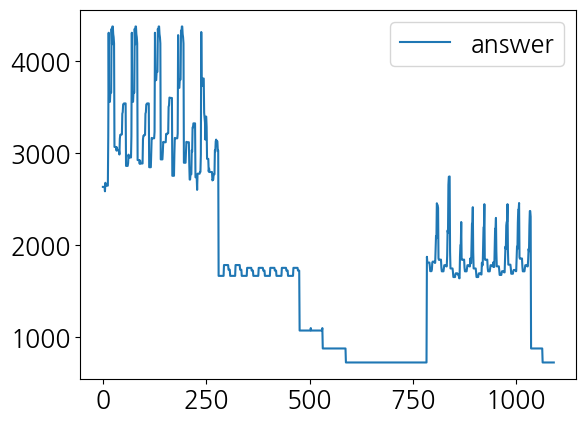

In [ ]:
sub_df['answer'] = result
sub_df.plot()

In [ ]:
# 저장
from google.colab import files

sub_df.to_csv('sub_df.csv', index = False)
files.download('sub_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>